# Programando algoritmos cuánticos IV: QSVM

En este notebook exploraremos por primera vez un algoritmo cuántico desarrollado exclusivamente para una tarea de Machine Learning (ML). Aunque los algoritmo que hemos visto anteriormente pueden ser utilizados como subrutinas de de algoritmos de QML, estos no habían sido diseñados especialmente para esta tarea. El algoritmo que estudiaremos en este notebook, el Quantum Support Vector Machine (QSVM), fue introducido por científicos de IBM en este artículo [1](https://arxiv.org/pdf/1804.11326.pdf). Existen otras implementaciones, como la del grup del reconocido científico Seth Lloyd [2](https://arxiv.org/pdf/1307.0471.pdf). De hecho, su implementación se basa algoritmo HHL (que lleva su nombre), y muestra una mejora exponencial con respecto algoritmo clásico.

Para entender la utilidad de un ordenador cuántico en problemas de ML, y en concreto problemas de clasificación, vamos a revisitar algunos conceptos de los metodos de clasificación. En general, cuando nos dan una serie de datos para que los clasificamos, separarlos en su espacio original no suele ser una tarea fácil. Lo que solemos hacer es aplicar una serie de transformaciones no lineales con tal de crear un nuevo espacio en el que poder encontrar un hiperplano que separe nuestros datos. Un ejemplo sencillo es el siguiente:

<img src="figs/feature_space.png" width=500>

Como veis, cuando los datos estabán en su espacio original (es decir en el plano 1D), no podíamos encontrar una linea que separara las clases. En cambio, utilizando la funcion $y=x^2$, en el espacio 2D que crean las variables $x$ e $y$ somos capaces de encontrar un plano lineal que separe las dos clases. Si consideramos ahora un problema en el que nuestros datos son 2D, el proceso es el mismo:
<img src="figs/feature_space_2.png" width=500>

En general, nuestros datos son mucho más complejos y constan de multiples dimensiones. Por ejemplo, una imagen que contenga 100 pixels puede dibujarse como un punto en un espacio de 100 dimensiones. Aun así, el proceso es siempre el mismo, encontrar una transformación que nos lleve de nuestro espacio original a un nuevo espacio, que solemos llamar *feature space*, en el que podemos separar nuestros datos via un hiperplano. Para encontrar dicho hiperplano, el procedimiento más usual es calcular la distancia entre los puntos de nuestro dataset, de manera que el plano separa los puntos que están más cercanos entre sí. Estos métodos se reciben el nombre de máquinas de vector de soporte (o SVM por sus siglas en inglés), donde el vector de soporte es el plano del que hablabamos anteriormente.

<img src="figs/svm.png" width=200>

Los SVM son métodos de aprendizaje supervisado. Es decir, que para construir la recta $\vec{w}·\vec{x}-b=0$ de la figura anterior, no solo tenemos en cuenta la posición de nuestro dato $\vec{x}$ en el feature space, si no que también entra en la ecuación el *label* de dicho dato, $y$. No entraremos en los detalles de las SVM, podeís hechar un vistazo a la sección *Linear SVM* de este [artículo de la Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine). Con un SVM lineal, como el presentado en la figura anterior, solo podremos resolver problemas lineales. Para resolver problemas más complejos, necesitaremos utilizar una mapa no lineal, como $y=x^2$ o la función $\phi$ de figuras anteriores. Entonces, el concepto de distancia deja de ser una producto escalar entre dos vectores a ser calculado mediante un kernel:

$$
k(\vec{x_1}, \vec{x_2}) = \phi(\vec{x_1})·\phi(\vec{x_2})
$$

Existen diferentes tipos de kernels, dependiendo del problema que queramos resolver. Podeís ver diferentes formas de kernel en [aquí](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte#Funci%C3%B3n_Kernel). 


Ahora que entendemos el concepto de feature space y kernel, podemos hacernos la siguiente pregunta: ¿Que pasaría si mis datos a clasificar fueran tan complejos, que al encontrar una función $\phi$ óptima, computar el kernel fuera computacionalmente prohibitibo? Siguiendo la tónica de este curso, vamos a resolver este problem mediante un algoritmo cuántico! En concreto, vamos a estudiar un algoritmo, el QSVM, el cual requiere un número exponencial de operaciones si ha de ser calculado clásicamente, pero que tiene una solución mucho más eficiente si es resuelto mediante un ordenador cuántico.

## El problema

Vamos a tratar de clasificar el [Breast Cancer Wisconsin (Diagnostic) Data Set ](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). El problema consiste en clasificar una serie de tumores entre benignos o malignos. El dataset consiste en 569 elementos, con 32 atributos cada uno. Dado nuestro objetivo es implementar el QSVM machine en el QPU de IBM, con un numéro de qubits limitado, vamos a reducir el número de atributos mediante el [análisis de componentes principales](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales) (PCA por sus siglas en inglés). 

In [61]:
from dataset import breast_cancer # asegurarse que el archivo dataset.py está en la misma carpeta que el notebook
from qiskit.aqua.utils import split_dataset_to_data_and_labels 
%matplotlib inline

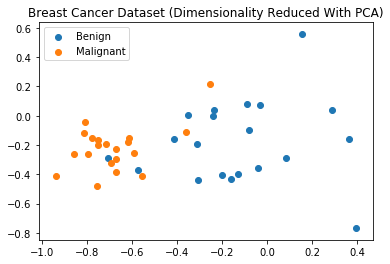

In [62]:
n = 2 # atríbutos que queremos extraer del dataset
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, _ = split_dataset_to_data_and_labels(training_input)
data_test, _ = split_dataset_to_data_and_labels(test_input)

### Solución clásica

Antes de solucionar el problema mediante QSVM, vamos a aplicar su análogo clásica. Podeís hacerlo de manera muy sencilla mediante la libreria *sklearn*. Primero cargamos las librerías necesarias:

In [63]:
import numpy as np
from matplotlib import pyplot  as plt
from sklearn import svm
from utils import svm_utils # asegurarse que el archivo utils.py está en la misma carpeta que el notebook

Para utilizar el SVM, simplemente utilizamos:

In [64]:
clf = svm.SVC(gamma = 'scale')
clf.fit(data_train[0], data_train[1]);

Vamos a explorar los resultados del SVM:

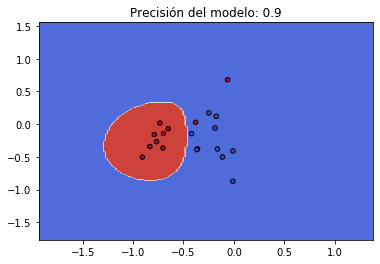

In [65]:
accuracy = clf.score(data_test[0], data_test[1])


X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
plt.scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.title('Precisión del modelo: '+str(accuracy));

In [66]:
X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

 El fondo de color corresponde a las zonas que el SVM asigna a una clase y a otra. Los puntos corresponden a los datos del test dataset. Como vemos, clasifica de manera correcta todos los puntos menos dos!

## First steps in Qiskit

In [67]:
import qiskit as qk

# Creating Qubits
q = qk.QuantumRegister(2)
# Creating Classical Bits
c = qk.ClassicalRegister(2)

### Define and print empty circuit

So far we only have an empty quantum circuit with 2 qubits (`q0_0` and `q0_1`) and 2 classical registers (`c0_0` and `c0_1`).

In [68]:
circuit = qk.QuantumCircuit(q, c)
print(circuit)

          
q73_0: |0>
          
q73_1: |0>
          
  c3_0: 0 
          
  c3_1: 0 
          


### Add gates to the qubits

As an example we add a Hadamard gate $H$ to the 0-th qubit and a Controlled-Not (also called Controlled-X, CNOT or CX) gate to the circuit, where the control qubit is qubit 0 and the target qubit is qubit 1.

**What do these qubits do?**

The initial state of `q0_0` is $\vert 0 \rangle_0$ and we first apply a Hadamard on it $H \vert 0 \rangle_0 = \frac{1}{\sqrt{2}} (\vert 0 \rangle_0 + \vert 1 \rangle_0)$.

At this point `q0_1` is still in the ground state $\vert 0 \rangle_1$ and the state of the whole circuit can be described as $\frac{1}{\sqrt{2}} (\vert 0 \rangle_0 + \vert 1 \rangle_0) \otimes \vert 0 \rangle_1$

The CNOT gate now applies a $X$ gate to `q0_1` if `q0_0` is in the $\vert 1 \rangle$ state otherwise nothing happens to `q0_1` which is the same as applying the unity matrix $\mathbb{1}$. This can be fromally writen as $\vert 0 \rangle \langle 0 \vert_0 \otimes \mathbb{1}_1 + \vert 1 \rangle \langle 1 \vert_0 \otimes X_1$.

The final state after these two gates is $\frac{1}{\sqrt{2}} (\vert 00 \rangle_{0,1} + \vert 11 \rangle_{0,1})$

In [69]:
# Initialize empty circuit
circuit = qk.QuantumCircuit(q, c)
# Hadamard Gate on the first Qubit
circuit.h(q[0])
# CNOT Gate on the first and second Qubits
circuit.cx(q[0], q[1])
# Measuring the Qubits
circuit.measure(q, c)
print (circuit)

          ┌───┐     ┌─┐   
q73_0: |0>┤ H ├──■──┤M├───
          └───┘┌─┴─┐└╥┘┌─┐
q73_1: |0>─────┤ X ├─╫─┤M├
               └───┘ ║ └╥┘
  c3_0: 0 ═══════════╩══╬═
                        ║ 
  c3_1: 0 ══════════════╩═
                          


### Run the circuit on the quantum simulator

In a next step we run this circuit on a quantum simulator.
The measurements that we added before at the end of the circuit will measure if the single qubits are either in the state $\vert 0 \rangle$ or $\vert 1 \rangle$ by returning writing the classical bits 0 or 1 into the classical register.

In [70]:
# Using Qiskit Aer's Qasm Simulator: Define where do you want to run the simulation.
simulator = qk.BasicAer.get_backend('qasm_simulator')

# Simulating the circuit using the simulator to get the result
job = qk.execute(circuit, simulator, shots=100)
result = job.result()

# Getting the aggregated binary outcomes of the circuit.
counts = result.get_counts(circuit)
print (counts)

{'11': 48, '00': 52}


## Quantum Classification

Remember what is the idea of a classical SVM. We have a set of points that are in either one group or another and we want to find a line that separates these two groups. This line can be linear, but it can also be much more complex, which can be achieved by the use of Kernels.

**So what will we need in the case of a quantum computer?**

- 1st we will have to translate the classical data point $\vec{x}$ into a quantum datapoint $\vert \Phi{(\vec{x})} \rangle$. This can be achieved by a circuit $\mathcal{U}_{\Phi(\vec{x})} \vert 0 \rangle $. Where $\Phi()$ could be any classical function applied on the classical data $\vec{x}$.

- 2nd we need a parameterized quantum circuit $W( \theta )$ that processes the data in a way that in the end we...

- 3rd can apply a measurement that returns a classical value $-1$ or $1$ for each classical input $\vec{x}$ that indentifies the label of the classical data.

**The most general ansatz**

Following these steps we can define an ansatz for this kind of problem which is $W(\theta) \mathcal{U}_{\Phi}(\vec{x}) \vert 0 \rangle$.

These kind of ansatz are called quantum variational circuits.

### Quantum SVM

In the case of a quantum SVM we will only used the quantum feature maps $\mathcal{U}_{\Phi(\vec{x})}$ to translate the classical data into quantum states and build the Kernel of the SVM out of these quantum states. After calculating the Kernel matrix on the quantum computer we can train the Quantum SVM the same way as the classical SVM.

**Defining the Quantum Kernel**

The idea of the quantum kernel is exactly the same as in the classical case. We take the inner product $K(\vec{x}, \vec{z}) = \vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2 = \langle 0^n \vert \mathcal{U}_{\Phi(\vec{x})}^{t} \mathcal{U}_{\Phi(\vec{z})} \vert 0^n \rangle$, but now with the quantum feature maps $\mathcal{U}_{\Phi(\vec{x})}$. The idea is that if we choose a quantum feature maps that is not easy to simulate with a classical computer we might obtain a quantum advantage.

Side note: _There is no proof yet that the QSVM brings a quantum advantage, but the argument the authors of [1](https://arxiv.org/pdf/1804.11326.pdf) make, is that there is for sure no advantage if we use feature maps that are easy to simulate classically, because then we would not need a quantum computer to construct the Kernel._

**Feature map**

For the feature maps we use the ansatz $\mathcal{U}_{\Phi(x)} = U_{\Phi(x)} \otimes H^{\otimes n}$, where $U_{\Phi(x)} = \exp \left( i \sum_{S \in n} \phi_S(x) \prod_{i \in S} Z_i \right)$, which simplifies a lot when we (like in [1](https://arxiv.org/pdf/1804.11326.pdf)) only consider $S \leq 2$ interactions, which means we only let two qubits interact at a time.
For $S \leq 2$ the product $\prod_{i \in S}$ only leads to interactions $Z_i Z_j$ and non interacting terms $Z_i$. And the sum $\sum_{S \in n}$ over all these terms that are possible with $n$ qubits.

Finally we define the classical functions $\phi_i(\vec{x}) = x_i$ and $\phi_{i,j}(\vec{x}) = (\pi - x_i)( \pi- x_j)$.

If we write this ansatz for 2 qubits and $S \leq 2$ we see how it simplifies:

$$U_{\Phi(x)} = \exp \left(i \left(x_1 Z_1 + x_2 Z_2 + (\pi - x_1)( \pi- x_2) Z_1 Z_2 \right) \right)$$

We won't get into details to much here, why we would take this ansatz. It is simply an ansatz that is simple enough an leads to good results.

Finally we can define a depth of these circuits. Depth 2 means we repeat this ansatz two times. Which means our feature map becomes $U_{\Phi(x)} \otimes H^{\otimes n} \otimes U_{\Phi(x)} \otimes H^{\otimes n}$

**Measuring the Quantum Kernel**

Finally we need to extract the information about the quantum kernel again from the quantum circuit to feed it into the classical SVM algorithm. This is actual a non-trivial task, because we want to measure the overlap of two states $K(\vec{x}, \vec{z}) = \vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2$ but there is a smart way to estimate this overlap, in [1](https://arxiv.org/pdf/1804.11326.pdf) they used this circuit for that estimation. 

<img src="Kernel_estimate.png" width=600>

Which simply uses the fact that **if** $\mathcal{U}_{\Phi(x)} = \mathcal{U}_{\Phi(z)}$ the whole unitary would simplify to $\mathbb{1}$ and the input should be equal to the output.
If we now measure the output, the frequency of the measurement string $0^n$ gives you an estimate of the overlap $\vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2$. (Because initially all qubits were $\vert 0 \rangle$)

### Build circuit for feature map

Qiskit Aqua provides a pre-built function that can construct the quantum circuit for $\mathcal{U}_{\Phi(x)}$. The Second Order Expansion refers to the number of interacting qubits which we called $S$ before. Since $S \leq 2$ we have terms with maximally two interacting qubits $Z_i Z_j$ (not for example $Z_i Z_j Z_k$), therefore Second Order.

The function `SecondOrderExpansion` has the arguments `feature_dimension`, which is the dimension of the input data $\vec{x}$ and at the same time also the number of qubits. `depth` is the number of repetitions of the feature map.

In [71]:
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

feature_map = SecondOrderExpansion(feature_dimension=2, 
                                   depth=1)

#### Print the feature map circuit

To print the feature map circuit we define an arbitrary vector `x` that we want to encode and construct the circuit for this datapoint.

In [72]:
x = np.array([0.6, 0.3])
feature_map.construct_circuit(x).draw(line_length = 100)

        ┌───────────────┐┌─────────────┐ ░                 ░      »
q_0: |0>┤ U3(pi/2,0,pi) ├┤ U3(0,0,1.2) ├─░─────────────────░───■──»
        ├───────────────┤└─────────────┘ ░ ┌─────────────┐ ░ ┌─┴─┐»
q_1: |0>┤ U3(pi/2,0,pi) ├────────────────░─┤ U3(0,0,0.6) ├─░─┤ X ├»
        └───────────────┘                ░ └─────────────┘ ░ └───┘»
«                         ░ 
«q_0: ────────────────■───░─
«     ┌────────────┐┌─┴─┐ ░ 
«q_1: ┤ U1(14.444) ├┤ X ├─░─
«     └────────────┘└───┘ ░ 


You might wonder now why there are no $Z_i$ and $Z_i Z_j$ matrices. This is simply because Qiskit does not provide these gates. We have to tranlate them into the gate set that Qiskit provides, which are manly 1-qubit rotations (here `U3`) and CNOTs. Qiskit does this work for us. It translates our feature map directly to gates that can be run on their qunatum computer. This is called compiling.

### QSVM Algorithm

Qiskit aqua also provides a pre-defined function to train the whole QSVM. Where we only have to provide the feature map, a training and a test set and Qiskit will do all the work for us.

Apart from finding the quantum Kernel the QSVM algorithm does only classical optimization. In the end there is no difference to the classical SVM, except that the Kernels are coming from a quantum distribution.

QSVM will minimize the loss 
$$L(W) = \sum_i w_i - \frac{1}{2}\sum_{i,j} y_i y_j w_i w_j K(\vec{x}_i, \vec{x}_j)$$
via optimizing the parameters $W$.

After training we can predict a label $y'$ of a data instance $\vec{s}$ with $y' = \text{sign}\left( \sum_i y_i w_i K(\vec{x}_i, \vec{s}) \right)$.

In [74]:
from qiskit.aqua.algorithms import QSVM

qsvm = QSVM(feature_map, training_input, test_input)

#### Run QSVM

Finally we will have to define where we would like to run this algorithm. For now we will run it on a local QASM Simulator. But the algorithm could also be sent to the IBMQ an be evaluated on a real quantum computer.

We will have to define the `shots`, which are the number of measurements that we will take for each qubit. And for better reproducability we also set here the random seeds `seed_simulator` and `see_transpiler`.

In [75]:
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit import BasicAer

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)

### Analyze output

`results` is a dictionary that contains elements like the kernel matrix, the label predictions and also the classical weights of the QSVM.

Let's have a quick look at them:

#### The kernel matrix for the training

Since the training set contains 40 elements, the kernel matrix has dimension 40x40

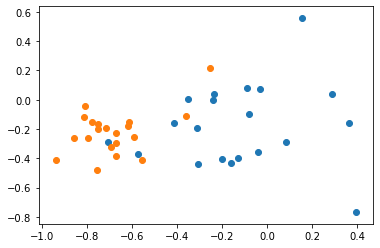

size training set: 40
Matrix dimension: (40, 40)


In [91]:
plt.scatter(training_input['Benign'][:,0], training_input['Benign'][:,1])
plt.scatter(training_input['Malignant'][:,0], training_input['Malignant'][:,1])
plt.show()
length_data = len(training_input['Benign']) + len(training_input['Malignant'])
print("size training set: {}".format(length_data))
print("Matrix dimension: {}".format(result['kernel_matrix_training'].shape))

The success ratio shows how accurate the QSVM predicts the labels

In [96]:
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.9


In [106]:
y_test = qsvm.predict(test_set, quantum_instance)

And here we plot the results. The first plot shows the label predictions of the QSVM and the second plot shows the test labels. `datasets.load_breast_cancer()`

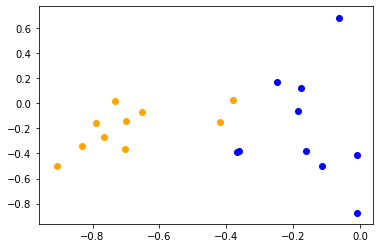

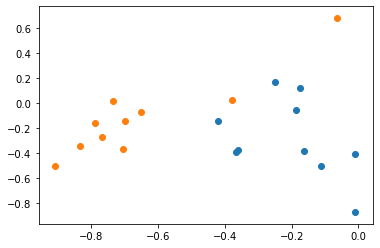

In [112]:
test_set = np.concatenate((test_input['Benign'], test_input['Malignant']))
plt.scatter(test_set[:, 0], test_set[:,1], c=y_test)
plt.show()

plt.scatter(test_input['Benign'][:,0], test_input['Benign'][:,1])
plt.scatter(test_input['Malignant'][:,0], test_input['Malignant'][:,1])
plt.show()

# References

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209–212 (2019).

[2] Rebentrost, P., Mohseni, M. & Lloyd, S. *Quantum support vector machine for big data classification*, Physical
review letters 113, 130503 (2014).